In [7]:
!pip install  scikit-learn plotly

In [6]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import time
import random
import plotly.express as px
import joblib
import plotly.graph_objects as go
import colorsys

In [ ]:
# !kaggle datasets download -d mexwell/telecom-shanghai-dataset

In [ ]:
# !unzip /kaggle/working/telecom-shanghai-dataset.zip

In [ ]:
# dir_path = "/kaggle/working/"
# df = pd.DataFrame()
# for file_name in os.listdir(dir_path):
#     if file_name.endswith('.xlsx'):
#         file_path = os.path.join(dir_path,file_name)
        
#         temp_df = pd.read_excel(file_path,engine='openpyxl')
#         df = pd.concat([df,temp_df],ignore_index = True)
# df.info()

In [ ]:
# df.info(show_counts=True)
# df.to_csv('data.csv',index=False)

In [8]:
df = pd.read_csv('/kaggle/input/shanghai-telecom-dataset-csv/data.csv')

In [9]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6952921 entries, 0 to 6952920
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   month       6952921 non-null  int64  
 1   date        6952921 non-null  int64  
 2   start time  6952921 non-null  object 
 3   end time    6952921 non-null  object 
 4   latitude    6236620 non-null  float64
 5   longitude   6236620 non-null  float64
 6   user id     6952921 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 371.3+ MB


In [10]:
z_scores_lat = (df['latitude'] - df['latitude'].mean()) / df['latitude'].std()
z_scores_long = (df['longitude'] - df['longitude'].mean()) / df['longitude'].std()

combined_z_scores = np.sqrt(z_scores_lat**2 + z_scores_long**2)
outliers = df[combined_z_scores > 3]
df_clean = df[combined_z_scores <= 3]



In [11]:
outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77796 entries, 2627 to 6948737
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   month       77796 non-null  int64  
 1   date        77796 non-null  int64  
 2   start time  77796 non-null  object 
 3   end time    77796 non-null  object 
 4   latitude    77796 non-null  float64
 5   longitude   77796 non-null  float64
 6   user id     77796 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 4.7+ MB


In [12]:
df_clean.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 6158824 entries, 184 to 6950027
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   month       6158824 non-null  int64  
 1   date        6158824 non-null  int64  
 2   start time  6158824 non-null  object 
 3   end time    6158824 non-null  object 
 4   latitude    6158824 non-null  float64
 5   longitude   6158824 non-null  float64
 6   user id     6158824 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 375.9+ MB


In [13]:

df_clean = df_clean.dropna(subset = ['latitude','longitude'])
df_clean.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
Index: 6158824 entries, 184 to 6950027
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   month       6158824 non-null  int64  
 1   date        6158824 non-null  int64  
 2   start time  6158824 non-null  object 
 3   end time    6158824 non-null  object 
 4   latitude    6158824 non-null  float64
 5   longitude   6158824 non-null  float64
 6   user id     6158824 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 375.9+ MB


In [14]:
base_stations = df_clean.groupby(['latitude', 'longitude']).size().reset_index(name='workload')
base_stations.info()
base_stations.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3014 entries, 0 to 3013
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   3014 non-null   float64
 1   longitude  3014 non-null   float64
 2   workload   3014 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 70.8 KB


,latitude,longitude,workload
0,29.151779,120.985563,27
1,29.526266,119.910488,2949
2,30.259244,120.219375,87
3,30.442177,120.618727,1400
4,30.705762,121.335120,1295


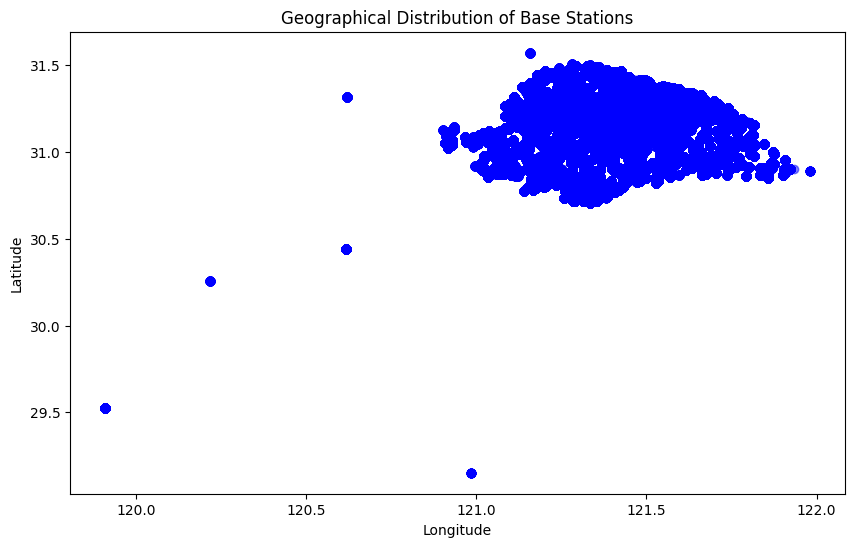

In [15]:
import matplotlib.pyplot as plt

# Geographical scatter plot of base stations
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['longitude'], df_clean['latitude'], c='blue', marker='o', alpha=0.5)
plt.title('Geographical Distribution of Base Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


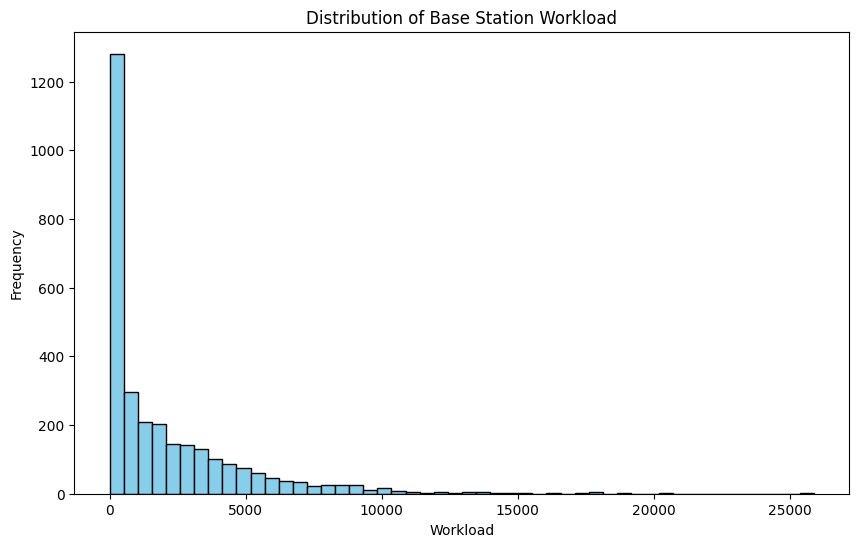

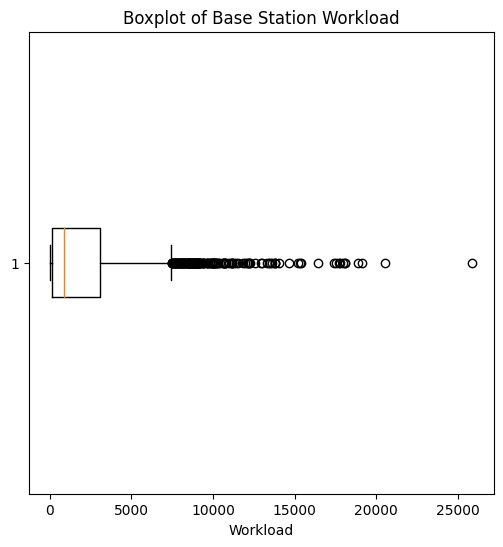

In [16]:
# Workload distribution histogram
plt.figure(figsize=(10, 6))
plt.hist(base_stations['workload'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Base Station Workload')
plt.xlabel('Workload')
plt.ylabel('Frequency')
plt.show()

# Workload boxplot
plt.figure(figsize=(6, 6))
plt.boxplot(base_stations['workload'], vert=False)
plt.title('Boxplot of Base Station Workload')
plt.xlabel('Workload')
plt.show()


In [17]:
fig = px.scatter_mapbox(base_stations,
                        lat="latitude",
                        lon="longitude",
                        color="workload",
                        size="workload",  # Bubble size can reflect workload too
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        size_max=15,
                        zoom=10,
                        mapbox_style="carto-positron",  # You can change the map style
                        title="Base Stations Workload Distribution")
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))

fig.show()

In [18]:
fig = px.density_mapbox(base_stations,
                        lat="latitude",
                        lon="longitude",
                        z="workload",  
                        radius=10,  
                        center=dict(lat=31.2304, lon=121.4737),  # Center on Shanghai
                        zoom=10,
                        mapbox_style="carto-positron", 
                        title="Heatmap of Base Station Workload")
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))

fig.show()

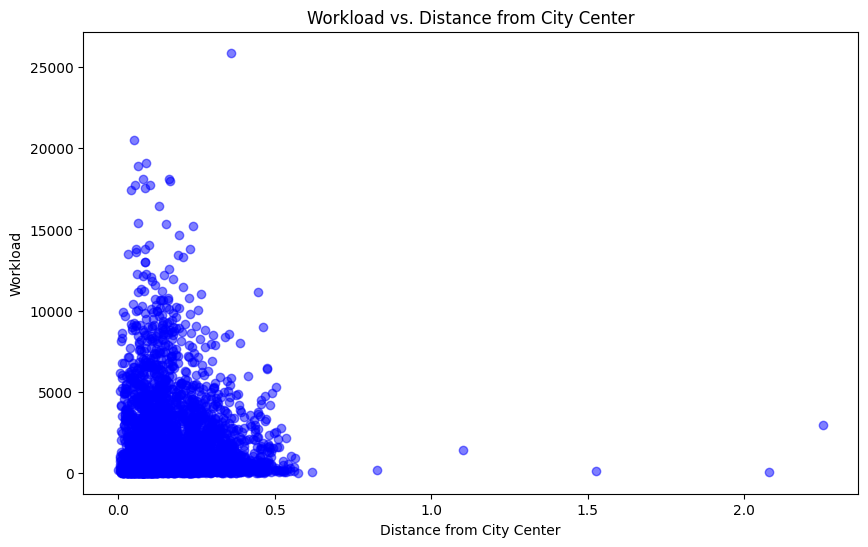

In [19]:
city_center_lat = base_stations['latitude'].mean()
city_center_lon = base_stations['longitude'].mean()


base_stations['distance_to_center'] = np.sqrt((base_stations['latitude'] - city_center_lat)**2 + (base_stations['longitude'] - city_center_lon)**2)


plt.figure(figsize=(10, 6))
plt.scatter(base_stations['distance_to_center'], base_stations['workload'], alpha=0.5, c='blue')
plt.title('Workload vs. Distance from City Center')
plt.xlabel('Distance from City Center')
plt.ylabel('Workload')
plt.show()


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



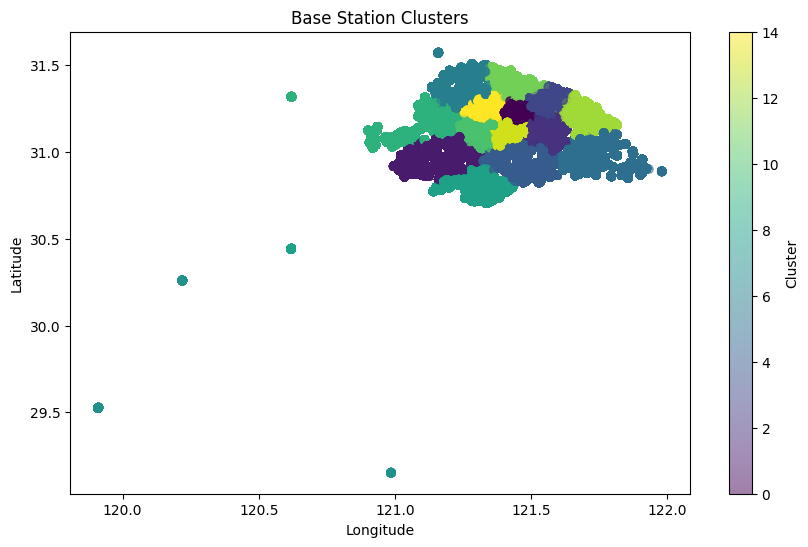

In [20]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15)
df_clean['cluster'] = kmeans.fit_predict(df_clean[['latitude', 'longitude']])

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['longitude'], df_clean['latitude'], c=df_clean['cluster'], cmap='viridis', alpha=0.5)
plt.title('Base Station Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()


In [21]:
def calculate_cost(placement, base_stations, num_edge_servers, beta=0.5):
    edge_servers = base_stations.iloc[placement]
    
    # Calculate delay
    delays = []
    for _, bs in base_stations.iterrows():
        distances = np.sqrt((edge_servers['latitude'] - bs['latitude'])**2 + 
                            (edge_servers['longitude'] - bs['longitude'])**2)
        delays.append(np.min(distances))
    delay_cost = np.mean(delays)
    
    # Calculate workload balance
    workloads = [0] * num_edge_servers
    for i, bs in base_stations.iterrows():
        distances = np.sqrt((edge_servers['latitude'] - bs['latitude'])**2 + 
                            (edge_servers['longitude'] - bs['longitude'])**2)
        closest_edge = np.argmin(distances)
        workloads[closest_edge] += bs['workload']
    workload_balance_cost = np.std(workloads)
    total_cost =beta * delay_cost + (1 - beta) * workload_balance_cost
    return total_cost

In [22]:
def genetic_algorithm(base_stations, num_edge_servers, population_size, num_generations, mutation_rate=0.1, beta=0.5):
    num_base_stations = len(base_stations)
    
    def create_individual():
        return random.sample(range(num_base_stations), num_edge_servers)
    
    def crossover(parent1, parent2):
        crossover_point = random.randint(1, num_edge_servers - 1)
        child = parent1[:crossover_point] 
        child =[gene for gene in parent2 if gene not in child]
        child += random.sample([gene for gene in range(num_base_stations) if gene not in child], 
                               num_edge_servers - len(child))
        return child
    
    def mutate(individual):
        if random.random() < mutation_rate:
            index_to_change = random.randint(0, num_edge_servers - 1)
            new_location = random.randint(0, num_base_stations - 1)
            while new_location in individual:
                new_location = random.randint(0, num_base_stations - 1)
            individual[index_to_change] = new_location
        return individual
    
    population = [create_individual() for _ in range(population_size)]
    best_costs = []
    
    for _ in range(num_generations):
        print("Current iteration :",_)
        fitness_scores = [1 / calculate_cost(ind, base_stations, num_edge_servers, beta) for ind in population]
        total_fitness = sum(fitness_scores)
        selection_probs = [score / total_fitness for score in fitness_scores]
        
        new_population = []
        for _ in range(population_size):
            parent1 = random.choices(population, weights=selection_probs)[0]
            parent2 = random.choices(population, weights=selection_probs)[0]
            child = crossover(parent1, parent2)
            child = mutate(child)
            print("Child to append",child)
            new_population.append(child)
        
        population = new_population
        best_individual = min(population, key=lambda x: calculate_cost(x, base_stations, num_edge_servers, beta))
        best_cost = calculate_cost(best_individual, base_stations, num_edge_servers, beta)
        best_costs.append(best_cost)
    
    return best_individual, best_costs

In [1]:
# best_individuals,best_costs = genetic_algorithm(base_stations,15,50,30)
best_individuals,best_costs = joblib.load('/kaggle/input/edge-server-placement-ga-outputs/ga_results.pkl')

In [24]:
# joblib.dump((best_individuals,best_costs),'ga_results.pkl')

In [25]:

def plot_edge_server_locations(base_stations, best_individuals):
    plt.figure(figsize=(10, 8))
    plt.scatter(base_stations['longitude'], base_stations['latitude'], 
                c='blue', alpha=0.5, label='Base Stations')
    
    edge_servers = base_stations.iloc[best_individuals]
    plt.scatter(edge_servers['longitude'], edge_servers['latitude'], 
                c='red', s=100, marker='*', label='Edge Servers')
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Base Stations and Optimal Edge Server Locations')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_best_costs(best_costs):
    plt.figure(figsize=(10, 6))
    plt.plot(best_costs)
    plt.xlabel('Generation')
    plt.ylabel('Best Cost')
    plt.title('Best Cost over Generations')
    plt.grid(True)
    plt.show()

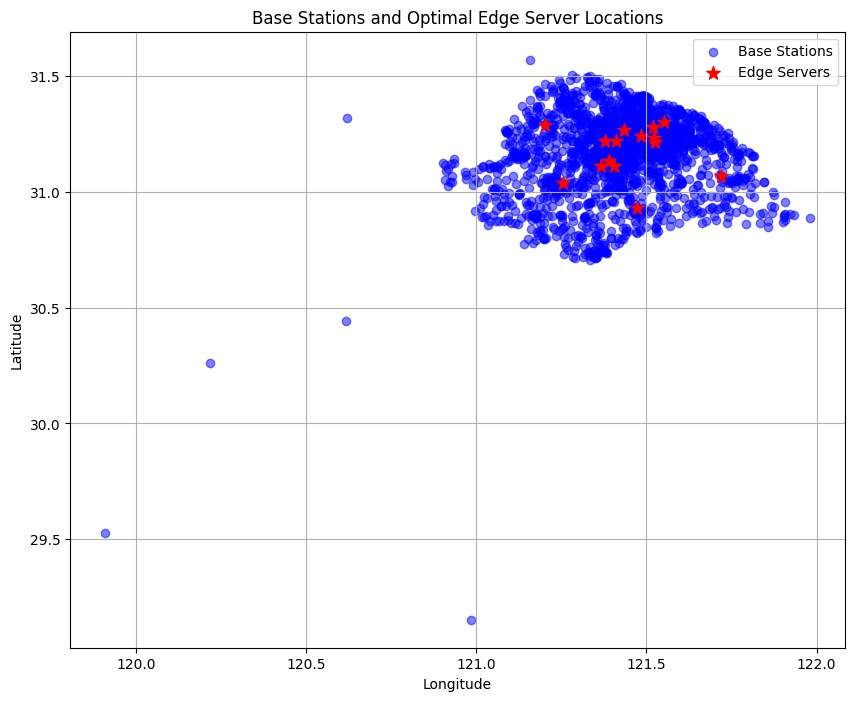

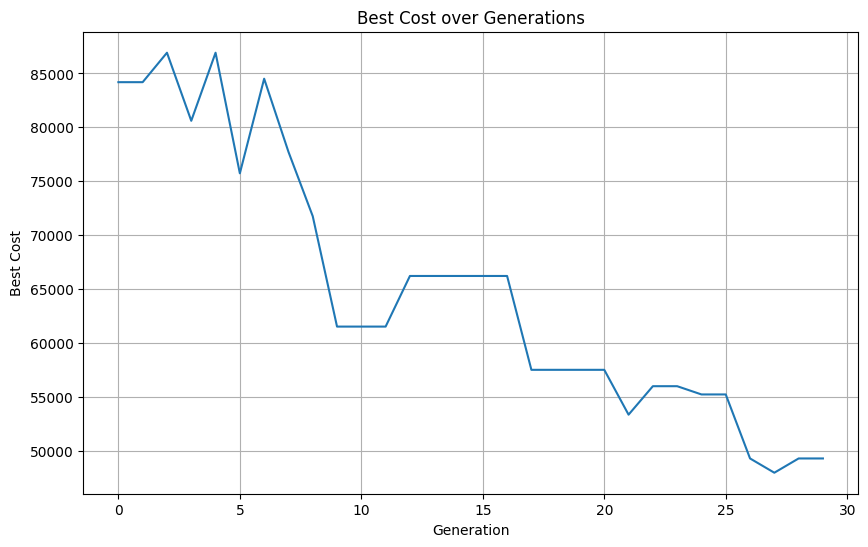

In [26]:
plot_edge_server_locations(base_stations, best_individuals)
plot_best_costs(best_costs)

In [27]:
def calculate_metrics(base_stations, best_individual):
    edge_servers = base_stations.iloc[best_individual]
    num_edge_servers = len(best_individual)
    
    workloads = [0] * num_edge_servers
    latencies = []
    
    for _, bs in base_stations.iterrows():
        distances = np.sqrt((edge_servers['latitude'] - bs['latitude'])**2 + 
                            (edge_servers['longitude'] - bs['longitude'])**2)
        closest_edge = np.argmin(distances)
        workloads[closest_edge] += bs['workload']
        latencies.append(np.min(distances))
    
    return workloads, latencies

In [28]:
# workloads,latencies = calculate_metrics(base_stations,best_individuals)
# joblib.dump((workloads,latencies),'derived_ga_results.pkl')
worloads,latencies = joblib.load('/kaggle/input/edge-server-placement-ga-outputs/ga_results.pkl')

In [2]:
def create_edge_server_map(base_stations, best_individuals):

    # Separate base stations and edge servers
    all_stations = base_stations.copy() 
    edge_servers = all_stations[all_stations.index.isin(best_individuals)]
    non_edge_servers = all_stations[~all_stations.index.isin(best_individuals)]

    # Function to find nearest edge server
    def find_nearest_edge(row):
        edge_servers = base_stations[base_stations['is_edge_server']]
        distances = np.sqrt((edge_servers['latitude'] - row['latitude'])**2 + 
                                (edge_servers['longitude'] - row['longitude'])**2)
        return distances.idxmin()

    # Assign each base station to nearest edge server
    non_edge_servers['nearest_edge'] = non_edge_servers.apply(find_nearest_edge, axis=1)
    # Generate distinct colors for each edge server
    num_edge_servers = len(best_individuals)
    colors = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' for r, g, b in
              [colorsys.hsv_to_rgb(i/num_edge_servers, 0.8, 0.8) for i in range(num_edge_servers)]]
    color_map = dict(zip(best_individuals, colors))
#     non_edge_servers.info(show_counts=True)
    # Create the scatter map for base stations
    fig = px.scatter_mapbox(non_edge_servers,
                            lat="latitude",
                            lon="longitude",
                            color="nearest_edge",  # Removed from non-edge_servers
                            size="workload",
                            hover_name=non_edge_servers.index,  # Use all_stations for hover info
                            hover_data=["workload"],
                            size_max=10,
                            opacity=0.6,
                            zoom=10,
                            mapbox_style="carto-positron",
                            title="Edge Server Placement and Base Station Coverage")

    # Assign colors based on nearest edge server (using all_stations)
    non_edge_servers['color'] = non_edge_servers['nearest_edge'].map(color_map)
    # Update color for non-edge_servers
    fig.update_traces(marker_color=non_edge_servers['color'])

    # Add edge servers as larger star markers
    fig.add_trace(go.Scattermapbox(
        lat=edge_servers['latitude'],
        lon=edge_servers['longitude'],
        mode='markers+text',
        marker=go.scattermapbox.Marker(
            size=2000,
            color=edge_servers.index.map(color_map),
            symbol='star',
            opacity=1
        ),
        text=edge_servers.index,
        textposition="top center",
        hoverinfo='text',
        name='Edge Servers'
    ))

    # Update layout for better visibility
    fig.update_layout(
        mapbox_zoom=5,
        mapbox_center={"lat": all_stations['latitude'].mean(
        ), "lon": all_stations['longitude'].mean()},
        margin={"r": 0, "t": 40, "l": 0, "b": 0},
        legend_title_text='Edge Servers',
        height=800
    )

    return fig


In [3]:

fig = create_edge_server_map(base_stations, best_individuals)
fig.show()


/tmp/ipykernel_30/2803228939.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_30/2803228939.py:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
def plot_workload_distribution(workloads):
    plt.figure(figsize=(8, 5))
    plt.bar(range(len(workloads)), workloads)
    plt.xlabel("Edge Server Index")
    plt.ylabel("Workload")
    plt.title("Workload Distribution Across Edge Servers")
    plt.tight_layout()
    plt.show()

def plot_latency_distribution(latencies):
    plt.figure(figsize=(8, 5))
    plt.hist(latencies, bins=30)
    plt.xlabel("Latency")
    plt.ylabel("Frequency")
    plt.title("Latency Distribution")
    plt.tight_layout()
    plt.show()

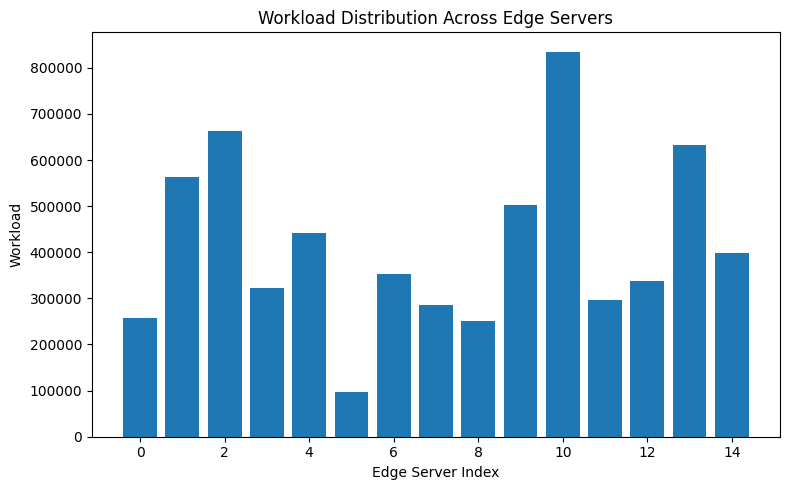

In [44]:
plot_workload_distribution(workloads)

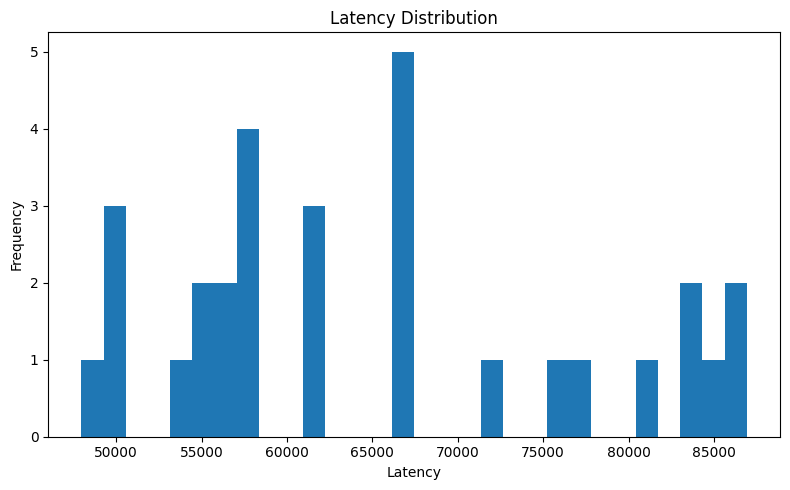

In [32]:
plot_latency_distribution(latencies)

In [47]:
def save_results(base_stations, best_individual, best_costs,workloads,latencies, filename_prefix='ga_results'):

    
    # Create a DataFrame with the base station results
    results_df = base_stations.copy()
    results_df['is_edge_server'] = results_df.index.isin(best_individual)
#     results_df['latency'] = latencies
    
    # Save base station results to CSV
    results_df.to_csv(f"{filename_prefix}_base_stations.csv", index=True)
    
    # Save best_costs to a separate CSV
    pd.DataFrame({'best_costs': best_costs}).to_csv(f"{filename_prefix}_best_costs.csv", index=False)
    
    # Save workloads to a separate CSV
    pd.DataFrame({'workloads': workloads}).to_csv(f"{filename_prefix}_workloads.csv", index=False)
    pd.DataFrame({'latencies': latencies}).to_csv(f"{filename_prefix}_latencies.csv", index=False)
    print(f"Results saved to {filename_prefix}_base_stations.csv, {filename_prefix}_best_costs.csv, and {filename_prefix}_workloads.csv")


In [48]:
save_results(base_stations, best_individuals, best_costs,workloads,latencies)

Results saved to ga_results_base_stations.csv, ga_results_best_costs.csv, and ga_results_workloads.csv
